## Détection des fraud dans l'assurance automobile

### Importation des libreries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from torchmetrics.classification import BinaryAccuracy

import numpy as np
from PIL import Image

import tensorflow as tf
from pt2keras import Pt2Keras
from pt2keras import converter

In [3]:
TRAIN_PATH = Path('C:/Users/hp/Documents/MASTER/Master2/data_viz/fraud_auto/dataset/train/train')
TEST_PATH = Path('C:/Users/hp/Documents/MASTER/Master2/data_viz/fraud_auto/dataset/test/test')

df_train = pd.read_csv(TRAIN_PATH/'train.csv')
df_test = pd.read_csv(TEST_PATH/'test.csv')
df_submission = pd.read_csv('/Users/hp/Documents/MASTER/Master2/data_viz/fraud_auto/dataset/sample_submission.csv')

## Exploration des données

In [4]:
df_train.shape, df_test.shape

((8079, 3), (3462, 2))

In [5]:
df_train.columns

Index(['image_id', 'filename', 'label'], dtype='object')

In [6]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=123, stratify=df_train['label'])

In [7]:
df_train.shape, df_val.shape, df_test.shape

((6463, 3), (1616, 3), (3462, 2))

In [8]:
df_train.head()

image_id  filename  label
723        724   724.jpg      0
3038      3039  3039.jpg      0
5226      5227  5227.jpg      1
3609      3610  3610.jpg      1
4341      4342  4342.jpg      0

In [9]:
df_test.head()

image_id  filename
0      8080  8080.jpg
1      8081  8081.jpg
2      8082  8082.jpg
3      8083  8083.jpg
4      8084  8084.jpg

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, path_df, transform=None):
        self.img_dir = img_dir
        self.path_df = path_df
        self.transform = transform

        self.img_names = path_df['filename'].values
        self.labels = path_df['label'].values

    def __getitem__(self, index):
        img_path = Path(self.img_dir)/self.img_names[index]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [16]:
train_dataset = CustomDataset(TRAIN_PATH/'images', df_train, train_transform)
val_dataset = CustomDataset(TRAIN_PATH/'images', df_val, test_transform)

In [17]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=4)
val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        num_workers=4)

In [18]:
for images, labels in val_loader:
    break

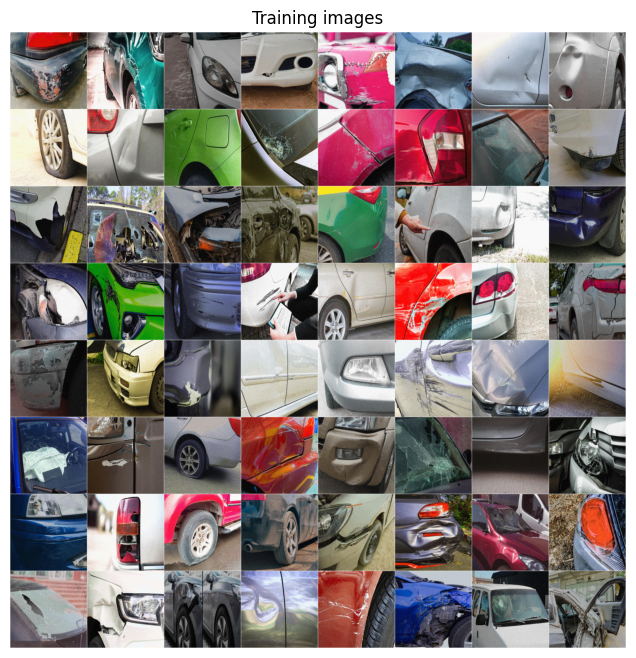

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

##  Model 

In [20]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate

        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        targets, preds, loss = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(preds, targets)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        targets, preds, loss = self._shared_step(batch)

        self.log("val_loss", loss)
        self.val_acc(preds, targets)
        self.log("val_acc", self.val_acc, prog_bar=True, on_epoch=True, on_step=False)

    def test_step(self, batch, batch_idx):
        pass

    def _shared_step(self, batch):
        images, targets = batch
        targets = targets.unsqueeze(1).float()
        
        logits = self.model(images)
        loss = F.binary_cross_entropy_with_logits(logits, targets)
        preds = torch.round(F.sigmoid(logits))
        
        return targets, preds, loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        return optim

In [21]:
L.pytorch.seed_everything(123)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
from torchvision.models import ResNet18_Weights
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18',
                               weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /teamspace/studios/this_studio/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [23]:
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
pytorch_model.fc = torch.nn.Linear(512, 1)

In [25]:
lightning_model = LightningModel(pytorch_model, learning_rate=0.1)

In [26]:
trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Missing logger folder: logs/my-model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | ResNet         | 11.2 M
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [27]:
torch.save(pytorch_model.state_dict(), "model.pt")

converter = Pt2Keras()
input_shape = (512,1)
keras_model: tf.keras.Model = converter.convert(pytorch_model, input_shape)

keras_model.save('.models/model.h5')

## Fonction de cout

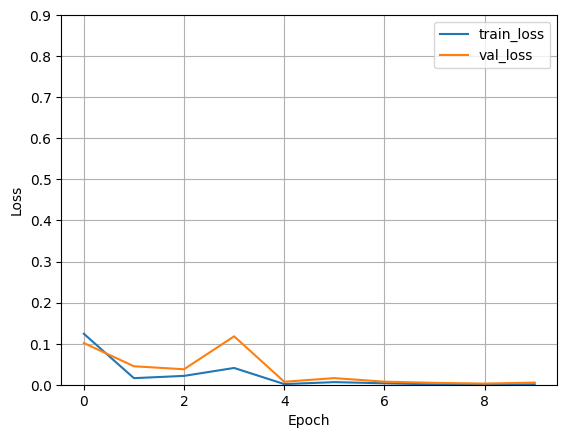

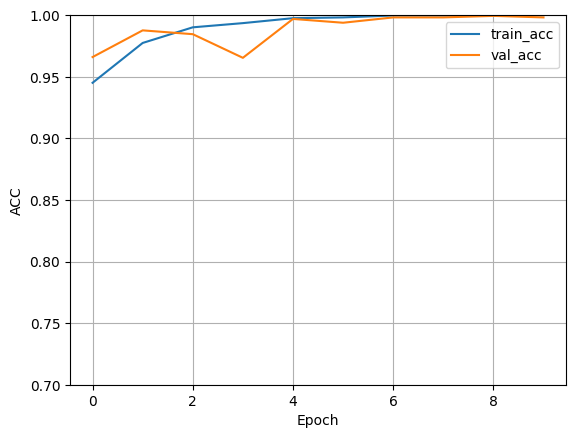

In [28]:
def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

plot_loss_and_acc(trainer.logger.log_dir)

In [35]:
trainer.validate(model=lightning_model, dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9981435537338257     │
│         val_loss          │   0.005261458456516266    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.005261458456516266, 'val_acc': 0.9981435537338257}]